# Measuring mass

- `isos` refers to stellar mass profiles. This isvocabulary inherited from Song who originally wrote the stellar mass profile measurement code used in Paper 1
- `quick` maps refer to the larger lower resolution maps we used (as oposed to the `hires` ones). We found that smothing the maps affected the mass measurement, so these are simple histogram maps without smoothing.

In [1]:
# #import functions from module
# import sys
# sys.path.append('/Users/fardila/Documents/GitHub/HSC_vs_hydro/')
# from functions import *

import numpy as np
import os
import pickle
import h5py
import matplotlib.pyplot as plt

%matplotlib inline 

/Users/fardila/anaconda/envs/hsc_hydro/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
Illustris_file_quick = '/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/Illustris/galaxies_stellarmaps_orig_11.2.hdf5'
TNG_file_quick = '/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/TNG/galaxies_stellarmaps_tng75_11.2.hdf5'

In [3]:
f = h5py.File(Illustris_file_quick, 'r')
n_galaxies = len(f['catsh_id'])
cat_sh_mstar = np.array(f['catsh_SubhaloMassType'][:, 4])

map_size = f['config'].attrs['map_range_min']
n_pixels = f['config'].attrs['map_npixel']
pixel_scale=2 * (map_size/n_pixels)
f.close()

print "number of galaxies: ", n_galaxies
print "map size in pixels: ", n_pixels
print "map size in kpc: ", map_size
print "pixel scale: ", pixel_scale

number of galaxies:  339
map size in pixels:  300
map size in kpc:  800.0
pixel scale:  5.333333333333333


In [9]:
#open pickels
illustris_masses_file='/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/Illustris/Illustris_masses_quick.pkl'
illustris_isos_file='/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/Illustris/Illustris_isos_quick.pkl'

tng_masses_file='/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/TNG/TNG_masses_quick.pkl'
tng_isos_file='/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/TNG/TNG_isos_quick.pkl'

def open_pkl(file_name):
    pkl = open(file_name,'rb')
    array = pickle.load(pkl)
    pkl.close()  
    return array

illustris_masses = open_pkl(illustris_masses_file)
illustris_isos = open_pkl(illustris_isos_file)

tng_masses = open_pkl(tng_masses_file)
tng_isos = open_pkl(tng_isos_file)

## 1d masses 

In [9]:
def get_1d_masses_from_iso(iso):
    m_1d_10, m_1d_30, m_1d_100, m_1d_500, m_1d_800 = oneD_mass(iso, 10.),\
                                                oneD_mass(iso, 30.),\
                                                oneD_mass(iso, 100.),\
                                                oneD_mass(iso, 500.),\
                                                oneD_mass(iso, 800.)
                    
    masses_1d = [m_1d_10, m_1d_30, m_1d_100, m_1d_500, m_1d_800] 
    
    return masses_1d

In [10]:
illustris_1d_masses=[]

for iso in illustris_isos:
    masses = get_1d_masses_from_iso(iso)
    illustris_1d_masses.append(masses)
    

In [15]:
tng_1d_masses=[]

for iso in tng_isos:
    masses = get_1d_masses_from_iso(iso)
    tng_1d_masses.append(masses)
    

## 2d masses 

In [ ]:
import sep

def find_closest(objects, x0=100., y0=100.):
    xs=objects['x']
    ys=objects['y']
    distances=np.sqrt(((xs-x0)**2) + ((ys-y0)**2))

    closest_index=np.argmin(distances)

    return objects[closest_index]

def get_mass_maps(sim_file, gal_n=0):

    # Load general simulation and galaxy properties
    f = h5py.File(sim_file, 'r')
    cat_sh_mstar = np.array(f['catsh_SubhaloMassType'][:, 4])

    cen_insitu = np.array(f['map_star_rho_insitu_xy'])
    cen_exsitu = np.array(f['map_star_rho_exsitu_xy'])
    map_stars_cen = cen_exsitu + cen_insitu

    fuzz_insitu = np.array(f['map_star_rho_fuzz_insitu_xy'])
    fuzz_exsitu = np.array(f['map_star_rho_fuzz_exsitu_xy'])
    map_stars_fuzz = fuzz_exsitu + fuzz_insitu

    sats_insitu = np.array(f['map_star_rho_oshs_insitu_xy'])
    sats_exsitu = np.array(f['map_star_rho_oshs_exsitu_xy'])
    map_stars_sats = sats_exsitu + sats_insitu

    map_size = f['config'].attrs['map_range_min']
    n_pixels = f['config'].attrs['map_npixel']
    pixel_scale=2 * (map_size/n_pixels)

    f.close()

    #make maps
    img_cen = map_stars_cen[gal_n] * (pixel_scale ** 2) # Central
    img_sat = map_stars_sats[gal_n] * (pixel_scale ** 2) # Satellites
    img_icl = map_stars_fuzz[gal_n] * (pixel_scale ** 2) # Diffuse
    img_cen_sat = (img_cen + img_sat)           # Central + Satellites
    img_cen_icl = (img_cen + img_icl)           # Central + Satellites
    img_all = (img_cen + img_sat + img_icl)           # Central + Satellites + Diffuse

    #catalog mass
    m_cat = np.log10(cat_sh_mstar[gal_n])

    return img_cen, img_cen_icl, pixel_scale, m_cat

def get_2d_masses(sim_file, sim_name, gal_n=0):
    
    #central pixels
    x0=150.
    y0=150.

    # Load maps
    mass_map_cen, mass_map_cen_icl, pixel_scale, m_cat = get_mass_maps(sim_file, gal_n=gal_n)

    #postage mass
    m_post = np.log10(np.sum(mass_map_cen))
    m_post_icl = np.log10(np.sum(mass_map_cen_icl))


    #ouput maps
    maps_location='/Users/fardila/Documents/GitHub/HSC_vs_hydro/Figures/fits_files/quick_800/'

    file_name=sim_name+'_'+str(gal_n)+'_xy'
    fits_prefix = maps_location + file_name
    #save_to_fits(mass_map_cen, fits_prefix + '_cen.fits')
    # save_to_fits(img_cen_sat, fits_prefix + '_cen_sat.fits')
    # save_to_fits(img_cen_icl, fits_prefix + '_cen_icl.fits')
    # save_to_fits(img_all, fits_prefix + '_all.fits')

    data=mass_map_cen
    suffix='_cen'

    ###########################################################################
    #get background
    bkg = sep.Background(data, bw=10, bh=10, fw=5, fh=5)
    bkg_subtraced_data = data - bkg

    thresh = 50 * bkg.globalrms
    objects = sep.extract(bkg_subtraced_data, thresh, minarea = 100,
                          deblend_nthresh=24, deblend_cont=0.1)

    #find object closest to image center
    obj = find_closest(objects, x0=x0, y0=y0)

    #ellipse parameters
    theta = obj['theta']
    q = obj['b']/ obj['a']

    a_10, a_30, a_100, a_500, a_800 = (10. / pixel_scale), (30. / pixel_scale), (100. / pixel_scale),\
                                        (500. / pixel_scale), (800. / pixel_scale)
    b_10, b_30, b_100, b_500, b_800 =  a_10 * q, a_30 * q, a_100 * q, a_500 * q, a_800 * q
    
    #2D masses
    flux_10, fluxerr_10, flag_10 = sep.sum_ellipse(data, x0, y0,
                                                   a_10, b_10, theta)
    flux_30, fluxerr_30, flag_30 = sep.sum_ellipse(data, x0, y0,
                                                   a_30, b_30, theta)
    flux_100, fluxerr_100, flag_100 = sep.sum_ellipse(data, x0, y0,
                                                      a_100, b_100, theta)
    flux_500, fluxerr_500, flag_500 = sep.sum_ellipse(data, x0, y0,
                                                      a_500, b_500, theta)
    flux_800, fluxerr_800, flag_800 = sep.sum_ellipse(data, x0, y0,
                                                      a_800, b_800, theta)
    
    m_2d_10, m_2d_30, m_2d_100, m_2d_500, m_2d_800 = np.log10(flux_10), \
                                                        np.log10(flux_30), \
                                                        np.log10(flux_100), \
                                                        np.log10(flux_500), \
                                                        np.log10(flux_800)


    masses = [m_2d_10,m_2d_30, m_2d_100, m_2d_500, m_2d_800]

    return masses

In [ ]:
illustris_2d_masses=[]

for i in range(339):  

    print(i)

    illustris_2d_mass = get_2d_masses(Illustris_file_quick,'Illustris',gal_n=i)

    
    illustris_2d_masses.append(illustris_2d_mass)

In [ ]:
tng_2d_masses=[]

for i in range(235):  

    print(i)

    tng_2d_mass = get_2d_masses(TNG_file_quick,'TNG',gal_n=i)

    
    tng_2d_masses.append(tng_2d_mass)

### save masses 

In [16]:
#1D
# np.save('/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/Illustris/illustris_1d_masses.npy',illustris_1d_masses)
# np.save('/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/TNG/tng_1d_masses.npy',tng_1d_masses)

#2D
# np.save('/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/Illustris/illustris_2d_masses.npy',illustris_2d_masses)
# np.save('/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/TNG/tng_2d_masses.npy',tng_2d_masses)


### load masses 

In [18]:
#1D
illustris_1d_masses = np.load('/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/Illustris/illustris_1d_masses.npy')
tng_1d_masses = np.load('/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/TNG/tng_1d_masses.npy')

#2D
illustris_2d_masses = np.load('/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/Illustris/illustris_2d_masses.npy')
tng_2d_masses = np.load('/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/TNG/tng_2d_masses.npy')

In [20]:
illustris_m_1d_10 = np.array([gal[0] for gal in illustris_1d_masses])
illustris_m_1d_30 = np.array([gal[1] for gal in illustris_1d_masses])
illustris_m_1d_100 = np.array([gal[2] for gal in illustris_1d_masses])
illustris_m_1d_500 = np.array([gal[3] for gal in illustris_1d_masses])
illustris_m_1d_800 = np.array([gal[4] for gal in illustris_1d_masses])

illustris_m_2d_10 = np.array([gal[0] for gal in illustris_2d_masses])
illustris_m_2d_30 = np.array([gal[1] for gal in illustris_2d_masses])
illustris_m_2d_100 = np.array([gal[2] for gal in illustris_2d_masses])
illustris_m_2d_500 = np.array([gal[3] for gal in illustris_2d_masses])
illustris_m_2d_800 = np.array([gal[4] for gal in illustris_2d_masses])

illustris_diff_2d_1d_10 = illustris_m_2d_10-illustris_m_1d_10
illustris_diff_2d_1d_30 = illustris_m_2d_30-illustris_m_1d_30
illustris_diff_2d_1d_100 = illustris_m_2d_100-illustris_m_1d_100
illustris_diff_2d_1d_500 = illustris_m_2d_500-illustris_m_1d_500
illustris_diff_2d_1d_800 = illustris_m_2d_800-illustris_m_1d_800

In [29]:
tng_m_1d_10 = np.array([gal[0] for gal in tng_1d_masses])
tng_m_1d_30 = np.array([gal[1] for gal in tng_1d_masses])
tng_m_1d_100 = np.array([gal[2] for gal in tng_1d_masses])
tng_m_1d_500 = np.array([gal[3] for gal in tng_1d_masses])
tng_m_1d_800 = np.array([gal[4] for gal in tng_1d_masses])

tng_m_2d_10 = np.array([gal[0] for gal in tng_2d_masses])
tng_m_2d_30 = np.array([gal[1] for gal in tng_2d_masses])
tng_m_2d_100 = np.array([gal[2] for gal in tng_2d_masses])
tng_m_2d_500 = np.array([gal[3] for gal in tng_2d_masses])
tng_m_2d_800 = np.array([gal[4] for gal in tng_2d_masses])

tng_diff_2d_1d_10 = tng_m_2d_10-tng_m_1d_10
tng_diff_2d_1d_30 = tng_m_2d_30-tng_m_1d_30
tng_diff_2d_1d_100 = tng_m_2d_100-tng_m_1d_100
tng_diff_2d_1d_500 = tng_m_2d_500-tng_m_1d_500
tng_diff_2d_1d_800 = tng_m_2d_800-tng_m_1d_800

# plots to compare masses

## 1D vs 2D 

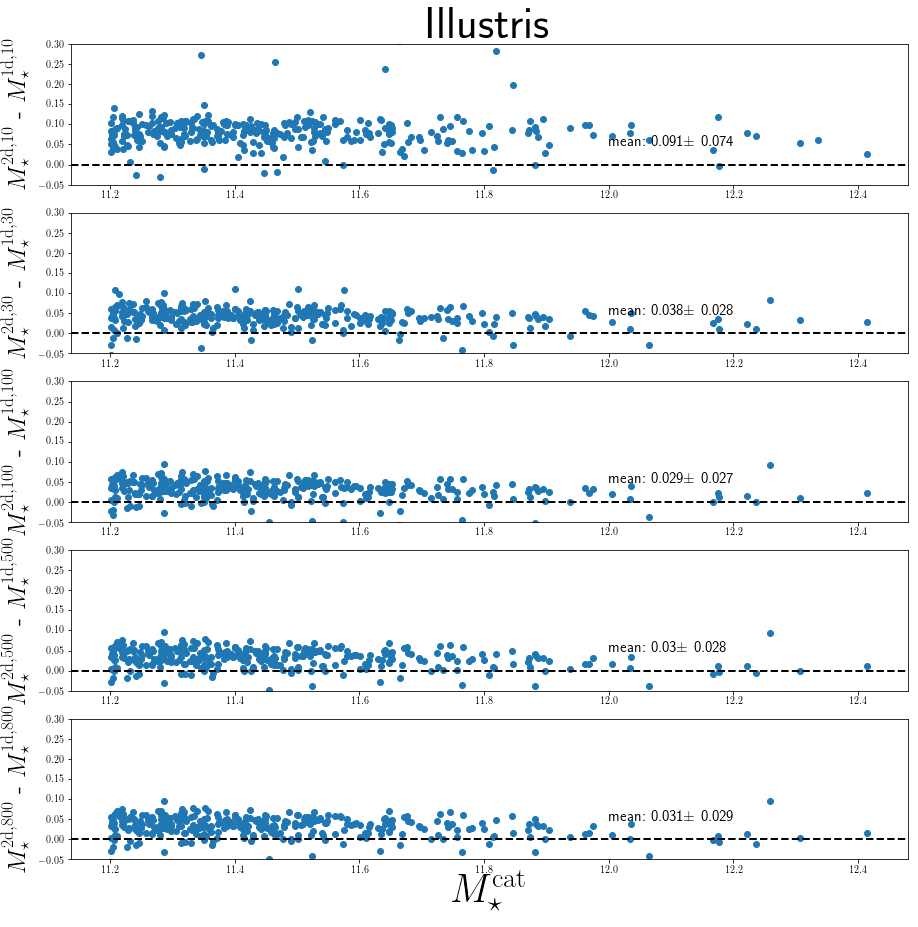

In [28]:
plt.figure(figsize=[15,15])
ax1=plt.subplot(511)
ax2=plt.subplot(512)
ax3=plt.subplot(513)
ax4=plt.subplot(514)
ax5=plt.subplot(515)

ax1.scatter(illustris_m_cat[illustris_diff_2d_1d_10<100], illustris_diff_2d_1d_10[illustris_diff_2d_1d_10<100])
# ax1.plot(xs, illustris_diff_cat_post_line(xs))
ax1.axhline(0,c="k",linewidth=2,linestyle='--')
ax1.text(12, 0.05,'mean: ' + str(round(np.mean(illustris_diff_2d_1d_10),3))+r'$\pm$ '+str(round(np.std(illustris_diff_2d_1d_10),3)),
         fontsize=15)
ax1.set_ylabel(r'$M_{\star}^{\mathrm{2d, 10}}$ - $M_{\star}^{\mathrm{1d, 10}}$ ', fontsize=25)

ax2.scatter(illustris_m_cat[illustris_diff_2d_1d_30<100], illustris_diff_2d_1d_30[illustris_diff_2d_1d_30<100])
# ax2.plot(xs, illustris_diff_cat_post_icl_line(xs))
ax2.axhline(0,c="k",linewidth=2,linestyle='--')
ax2.text(12, 0.05,'mean: ' + str(round(np.mean(illustris_diff_2d_1d_30),3))+r'$\pm$ '+str(round(np.std(illustris_diff_2d_1d_30),3)),
         fontsize=15)
ax2.set_ylabel(r'$M_{\star}^{\mathrm{2d, 30}}$ - $M_{\star}^{\mathrm{1d, 30}}$ ', fontsize=25)

ax3.scatter(illustris_m_cat[illustris_diff_2d_1d_100<100], illustris_diff_2d_1d_100[illustris_diff_2d_1d_100<100])
# ax3.plot(xs, illustris_diff_cat_1d100_line(xs))
ax3.axhline(0, c="k",linewidth=2, linestyle='--')
ax3.text(12, 0.05,'mean: ' + str(round(np.mean(illustris_diff_2d_1d_100),3))+r'$\pm$ '+str(round(np.std(illustris_diff_2d_1d_100),3)),
         fontsize=15)
ax3.set_ylabel(r'$M_{\star}^{\mathrm{2d, 100}}$ - $M_{\star}^{\mathrm{1d, 100}}$ ', fontsize=25)

ax4.scatter(illustris_m_cat[illustris_diff_2d_1d_500<100], illustris_diff_2d_1d_500[illustris_diff_2d_1d_500<100])
# ax2.plot(xs, illustris_diff_cat_post_icl_line(xs))
ax4.axhline(0,c="k",linewidth=2,linestyle='--')
ax4.text(12, 0.05,'mean: ' + str(round(np.mean(illustris_diff_2d_1d_500),3))+r'$\pm$ '+str(round(np.std(illustris_diff_2d_1d_500),3)),
         fontsize=15)
ax4.set_ylabel(r'$M_{\star}^{\mathrm{2d, 500}}$ - $M_{\star}^{\mathrm{1d, 500}}$ ', fontsize=25)

ax5.scatter(illustris_m_cat[illustris_diff_2d_1d_800<100], illustris_diff_2d_1d_800[illustris_diff_2d_1d_800<100])
# ax3.plot(xs, illustris_diff_cat_1d100_line(xs))
ax5.axhline(0, c="k",linewidth=2, linestyle='--')
ax5.text(12, 0.05,'mean: ' + str(round(np.mean(illustris_diff_2d_1d_800),3))+r'$\pm$ '+str(round(np.std(illustris_diff_2d_1d_800),3)),
         fontsize=15)
ax5.set_ylabel(r'$M_{\star}^{\mathrm{2d, 800}}$ - $M_{\star}^{\mathrm{1d, 800}}$ ', fontsize=25)




ax5.set_xlabel('$M_{\star}^{\mathrm{cat}}$', fontsize=40)
ax1.set_title('Illustris', fontsize=45)
#plt.tight_layout()

for ax in [ax1,ax2,ax3, ax4, ax5]:
    ax.set_ylim([-0.05,0.3])

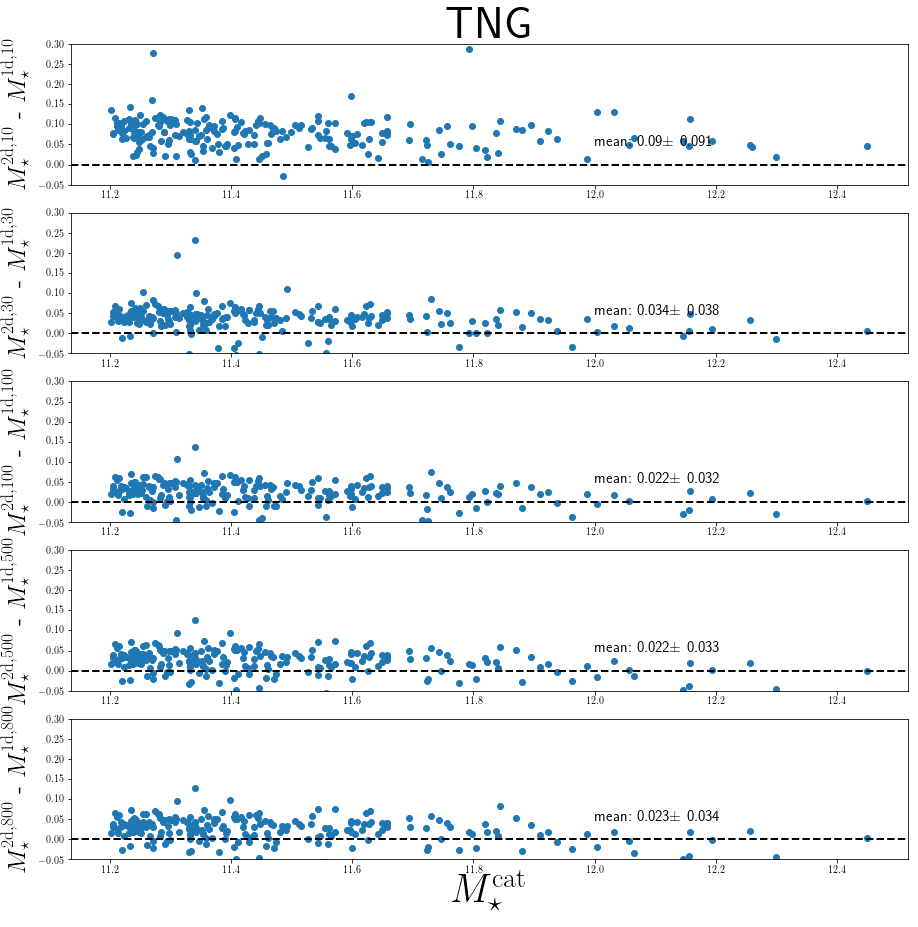

In [30]:
plt.figure(figsize=[15,15])
ax1=plt.subplot(511)
ax2=plt.subplot(512)
ax3=plt.subplot(513)
ax4=plt.subplot(514)
ax5=plt.subplot(515)

ax1.scatter(tng_m_cat[tng_diff_2d_1d_10<100], tng_diff_2d_1d_10[tng_diff_2d_1d_10<100])
# ax1.plot(xs, tng_diff_cat_post_line(xs))
ax1.axhline(0,c="k",linewidth=2,linestyle='--')
ax1.text(12, 0.05,'mean: ' + str(round(np.mean(tng_diff_2d_1d_10),3))+r'$\pm$ '+str(round(np.std(tng_diff_2d_1d_10),3)),
         fontsize=15)
ax1.set_ylabel(r'$M_{\star}^{\mathrm{2d, 10}}$ - $M_{\star}^{\mathrm{1d, 10}}$ ', fontsize=25)

ax2.scatter(tng_m_cat[tng_diff_2d_1d_30<100], tng_diff_2d_1d_30[tng_diff_2d_1d_30<100])
# ax2.plot(xs, tng_diff_cat_post_icl_line(xs))
ax2.axhline(0,c="k",linewidth=2,linestyle='--')
ax2.text(12, 0.05,'mean: ' + str(round(np.mean(tng_diff_2d_1d_30),3))+r'$\pm$ '+str(round(np.std(tng_diff_2d_1d_30),3)),
         fontsize=15)
ax2.set_ylabel(r'$M_{\star}^{\mathrm{2d, 30}}$ - $M_{\star}^{\mathrm{1d, 30}}$ ', fontsize=25)

ax3.scatter(tng_m_cat[tng_diff_2d_1d_100<100], tng_diff_2d_1d_100[tng_diff_2d_1d_100<100])
# ax3.plot(xs, tng_diff_cat_1d100_line(xs))
ax3.axhline(0, c="k",linewidth=2, linestyle='--')
ax3.text(12, 0.05,'mean: ' + str(round(np.mean(tng_diff_2d_1d_100),3))+r'$\pm$ '+str(round(np.std(tng_diff_2d_1d_100),3)),
         fontsize=15)
ax3.set_ylabel(r'$M_{\star}^{\mathrm{2d, 100}}$ - $M_{\star}^{\mathrm{1d, 100}}$ ', fontsize=25)

ax4.scatter(tng_m_cat[tng_diff_2d_1d_500<100], tng_diff_2d_1d_500[tng_diff_2d_1d_500<100])
# ax2.plot(xs, tng_diff_cat_post_icl_line(xs))
ax4.axhline(0,c="k",linewidth=2,linestyle='--')
ax4.text(12, 0.05,'mean: ' + str(round(np.mean(tng_diff_2d_1d_500),3))+r'$\pm$ '+str(round(np.std(tng_diff_2d_1d_500),3)),
         fontsize=15)
ax4.set_ylabel(r'$M_{\star}^{\mathrm{2d, 500}}$ - $M_{\star}^{\mathrm{1d, 500}}$ ', fontsize=25)

ax5.scatter(tng_m_cat[tng_diff_2d_1d_800<100], tng_diff_2d_1d_800[tng_diff_2d_1d_800<100])
# ax3.plot(xs, tng_diff_cat_1d100_line(xs))
ax5.axhline(0, c="k",linewidth=2, linestyle='--')
ax5.text(12, 0.05,'mean: ' + str(round(np.mean(tng_diff_2d_1d_800),3))+r'$\pm$ '+str(round(np.std(tng_diff_2d_1d_800),3)),
         fontsize=15)
ax5.set_ylabel(r'$M_{\star}^{\mathrm{2d, 800}}$ - $M_{\star}^{\mathrm{1d, 800}}$ ', fontsize=25)




ax5.set_xlabel('$M_{\star}^{\mathrm{cat}}$', fontsize=40)
ax1.set_title('TNG', fontsize=45)
#plt.tight_layout()

for ax in [ax1,ax2,ax3, ax4, ax5]:
    ax.set_ylim([-0.05,0.3])

## 2d vs catalog mass

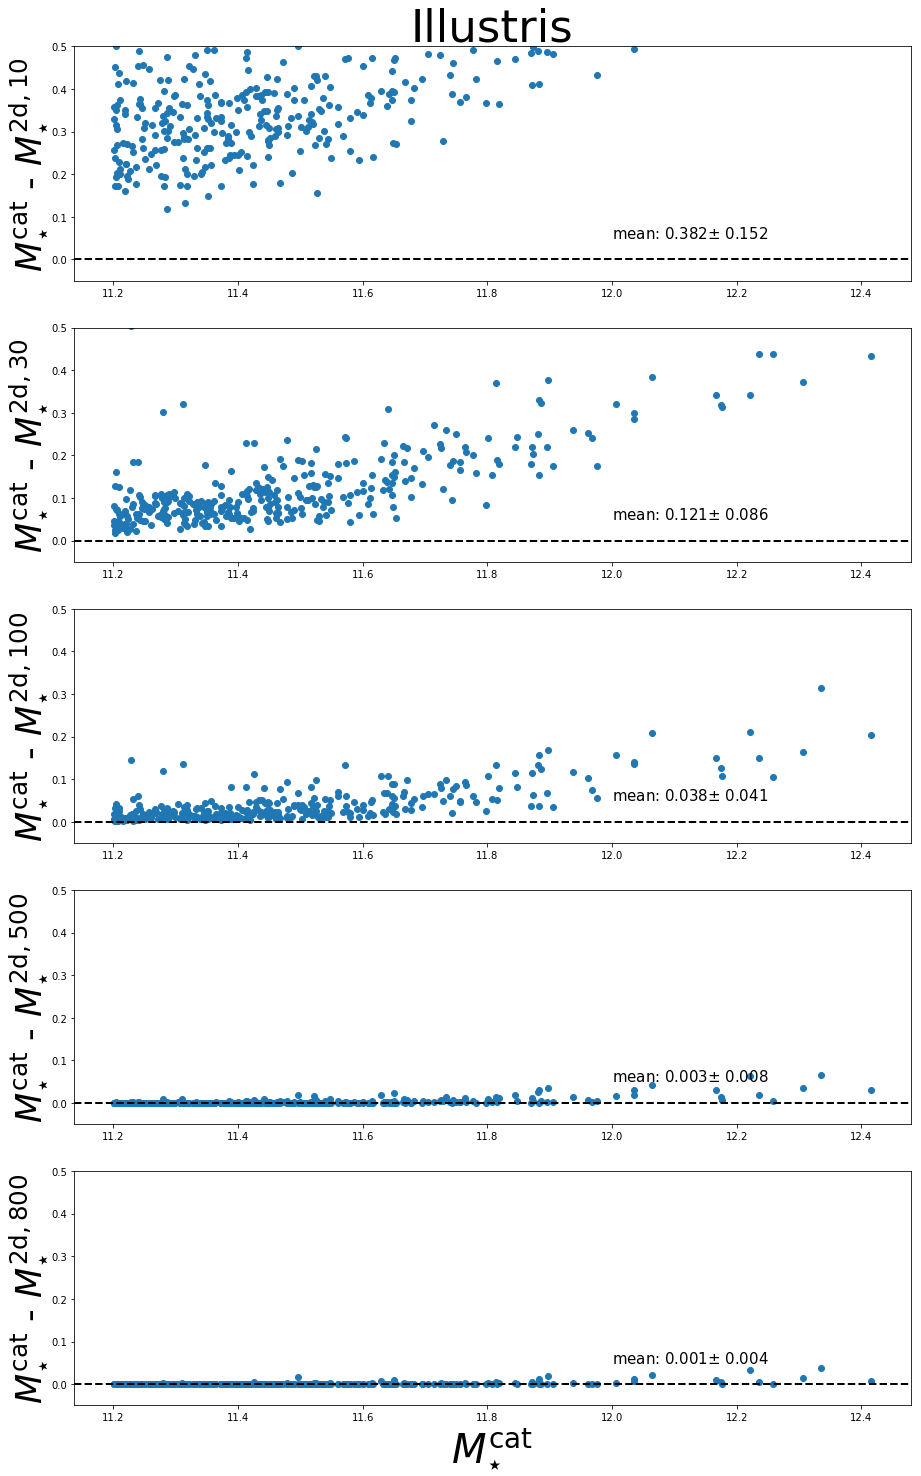

In [77]:
plt.figure(figsize=[15,25])
ax1=plt.subplot(511)
ax2=plt.subplot(512)
ax3=plt.subplot(513)
ax4=plt.subplot(514)
ax5=plt.subplot(515)


ax1.scatter(illustris_m_cat, illustris_m_cat - illustris_m_2d_10)
# ax1.plot(xs, illustris_diff_cat_post_line(xs))
ax1.axhline(0,c="k",linewidth=2,linestyle='--')
ax1.text(12, 0.05,'mean: ' + str(round(np.mean(illustris_m_cat - illustris_m_2d_10),3)) + r'$\pm$ '+\
         str(round(np.std(illustris_m_cat - illustris_m_2d_10),3)), fontsize=15)
ax1.set_ylabel(r'$M_{\star}^{\mathrm{cat}}$ - $M_{\star}^{\mathrm{2d, 10}}$', fontsize=35)

ax2.scatter(illustris_m_cat, illustris_m_cat - illustris_m_2d_30)
# ax2.plot(xs, illustris_diff_cat_post_icl_line(xs))
ax2.axhline(0,c="k",linewidth=2,linestyle='--')
ax2.text(12, 0.05,'mean: ' + str(round(np.mean(illustris_m_cat - illustris_m_2d_30),3)) + r'$\pm$ '+\
         str(round(np.std(illustris_m_cat - illustris_m_2d_30),3)), fontsize=15)
ax2.set_ylabel(r'$M_{\star}^{\mathrm{cat}}$ - $M_{\star}^{\mathrm{2d, 30}}$', fontsize=35)

ax3.scatter(illustris_m_cat, illustris_m_cat - illustris_m_2d_100)
# ax3.plot(xs, illustris_diff_cat_1d100_line(xs))
ax3.axhline(0, c="k",linewidth=2, linestyle='--')
ax3.text(12, 0.05,'mean: ' + str(round(np.mean(illustris_m_cat - illustris_m_2d_100),3)) + r'$\pm$ '+\
         str(round(np.std(illustris_m_cat - illustris_m_2d_100),3)), fontsize=15)
ax3.set_ylabel(r'$M_{\star}^{\mathrm{cat}}$ - $M_{\star}^{\mathrm{2d, 100}}$', fontsize=35)

ax4.scatter(illustris_m_cat, illustris_m_cat - illustris_m_2d_500)
# ax4.plot(xs, illustris_diff_2d_1d_30_line(xs))
ax4.axhline(0,c="k",linewidth=2,linestyle='--')
ax4.text(12, 0.05,'mean: ' + str(round(np.mean(illustris_m_cat - illustris_m_2d_500),3)) + r'$\pm$ '+\
         str(round(np.std(illustris_m_cat - illustris_m_2d_500),3)), fontsize=15)
ax4.set_ylabel(r'$M_{\star}^{\mathrm{cat}}$ - $M_{\star}^{\mathrm{2d, 500}}$', fontsize=35)

ax5.scatter(illustris_m_cat, illustris_m_cat - illustris_m_2d_800)
# ax5.plot(xs, illustris_diff_cat_1dextrap_line(xs))
ax5.axhline(0,c="k",linewidth=2,linestyle='--')
ax5.text(12, 0.05,'mean: ' + str(round(np.mean(illustris_m_cat - illustris_m_2d_800),3)) + r'$\pm$ '+\
         str(round(np.std(illustris_m_cat - illustris_m_2d_800),3)), fontsize=15)
ax5.set_ylabel(r'$M_{\star}^{\mathrm{cat}}$ - $M_{\star}^{\mathrm{2d, 800}}$', fontsize=35)




ax5.set_xlabel('$M_{\star}^{\mathrm{cat}}$', fontsize=40)
ax1.set_title('Illustris', fontsize=45)
#plt.tight_layout()

for ax in [ax1,ax2,ax3,ax4,ax5]:
    ax.set_ylim([-0.05,0.5])

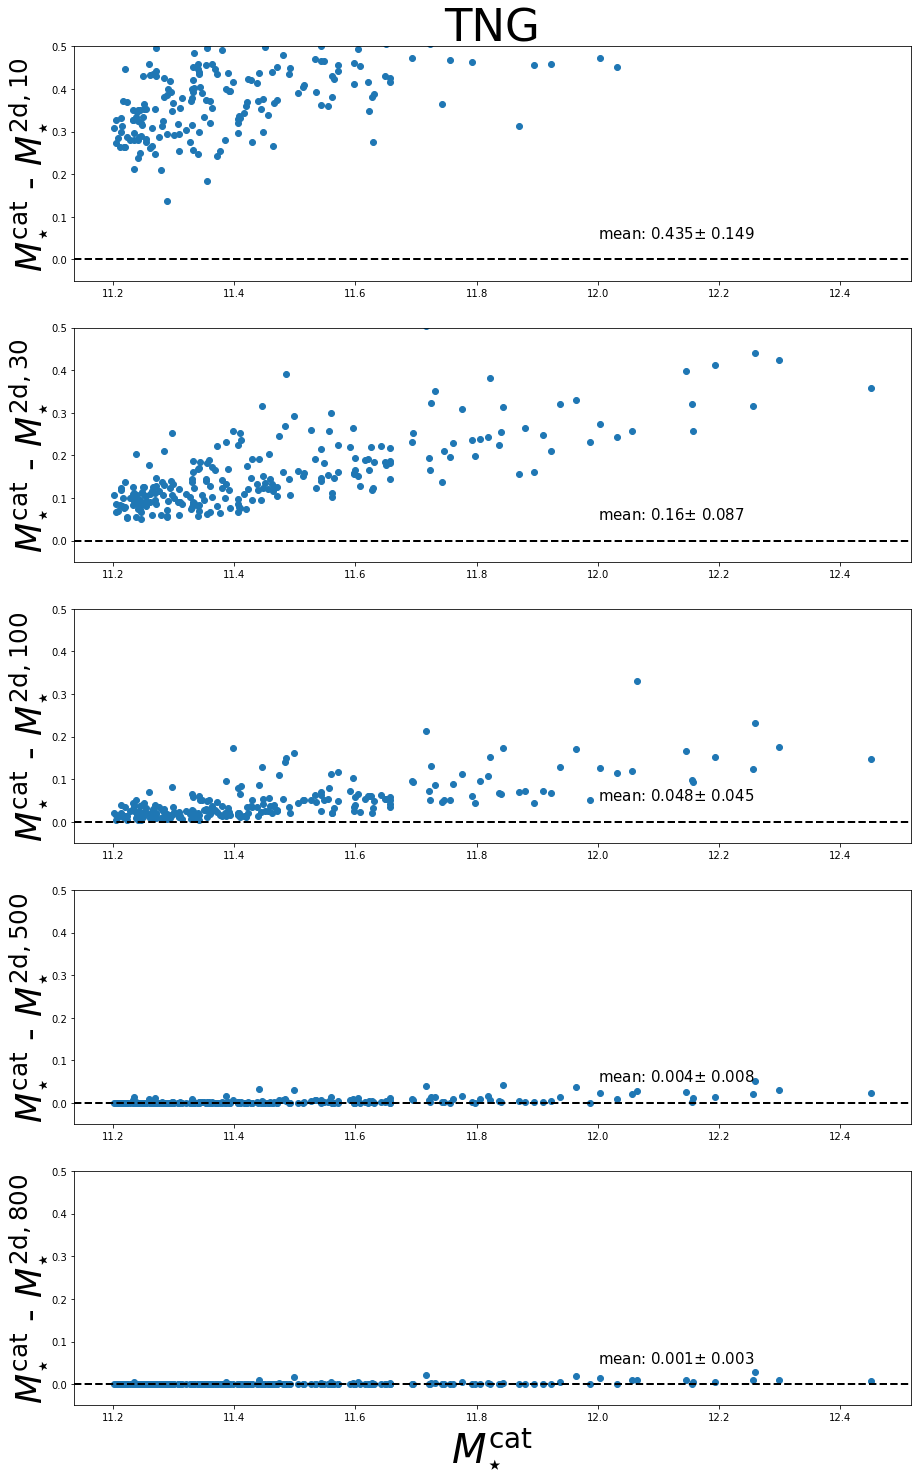

In [79]:
plt.figure(figsize=[15,25])
ax1=plt.subplot(511)
ax2=plt.subplot(512)
ax3=plt.subplot(513)
ax4=plt.subplot(514)
ax5=plt.subplot(515)


ax1.scatter(tng_m_cat, tng_m_cat - tng_m_2d_10)
# ax1.plot(xs, tng_diff_cat_post_line(xs))
ax1.axhline(0,c="k",linewidth=2,linestyle='--')
ax1.text(12, 0.05,'mean: ' + str(round(np.mean(tng_m_cat - tng_m_2d_10),3)) + r'$\pm$ '+\
         str(round(np.std(tng_m_cat - tng_m_2d_10),3)), fontsize=15)
ax1.set_ylabel(r'$M_{\star}^{\mathrm{cat}}$ - $M_{\star}^{\mathrm{2d, 10}}$', fontsize=35)

ax2.scatter(tng_m_cat, tng_m_cat - tng_m_2d_30)
# ax2.plot(xs, tng_diff_cat_post_icl_line(xs))
ax2.axhline(0,c="k",linewidth=2,linestyle='--')
ax2.text(12, 0.05,'mean: ' + str(round(np.mean(tng_m_cat - tng_m_2d_30),3)) + r'$\pm$ '+\
         str(round(np.std(tng_m_cat - tng_m_2d_30),3)), fontsize=15)
ax2.set_ylabel(r'$M_{\star}^{\mathrm{cat}}$ - $M_{\star}^{\mathrm{2d, 30}}$', fontsize=35)

ax3.scatter(tng_m_cat, tng_m_cat - tng_m_2d_100)
# ax3.plot(xs, tng_diff_cat_1d100_line(xs))
ax3.axhline(0, c="k",linewidth=2, linestyle='--')
ax3.text(12, 0.05,'mean: ' + str(round(np.mean(tng_m_cat - tng_m_2d_100),3)) + r'$\pm$ '+\
         str(round(np.std(tng_m_cat - tng_m_2d_100),3)), fontsize=15)
ax3.set_ylabel(r'$M_{\star}^{\mathrm{cat}}$ - $M_{\star}^{\mathrm{2d, 100}}$', fontsize=35)

ax4.scatter(tng_m_cat, tng_m_cat - tng_m_2d_500)
# ax4.plot(xs, tng_diff_2d_1d_30_line(xs))
ax4.axhline(0,c="k",linewidth=2,linestyle='--')
ax4.text(12, 0.05,'mean: ' + str(round(np.mean(tng_m_cat - tng_m_2d_500),3)) + r'$\pm$ '+\
         str(round(np.std(tng_m_cat - tng_m_2d_500),3)), fontsize=15)
ax4.set_ylabel(r'$M_{\star}^{\mathrm{cat}}$ - $M_{\star}^{\mathrm{2d, 500}}$', fontsize=35)

ax5.scatter(tng_m_cat, tng_m_cat - tng_m_2d_800)
# ax5.plot(xs, tng_diff_cat_1dextrap_line(xs))
ax5.axhline(0,c="k",linewidth=2,linestyle='--')
ax5.text(12, 0.05,'mean: ' + str(round(np.mean(tng_m_cat - tng_m_2d_800),3)) + r'$\pm$ '+\
         str(round(np.std(tng_m_cat - tng_m_2d_800),3)), fontsize=15)
ax5.set_ylabel(r'$M_{\star}^{\mathrm{cat}}$ - $M_{\star}^{\mathrm{2d, 800}}$', fontsize=35)




ax5.set_xlabel('$M_{\star}^{\mathrm{cat}}$', fontsize=40)
ax1.set_title('TNG', fontsize=45)
#plt.tight_layout()

for ax in [ax1,ax2,ax3,ax4,ax5]:
    ax.set_ylim([-0.05,0.5])

## 1d vs. catalog mass 

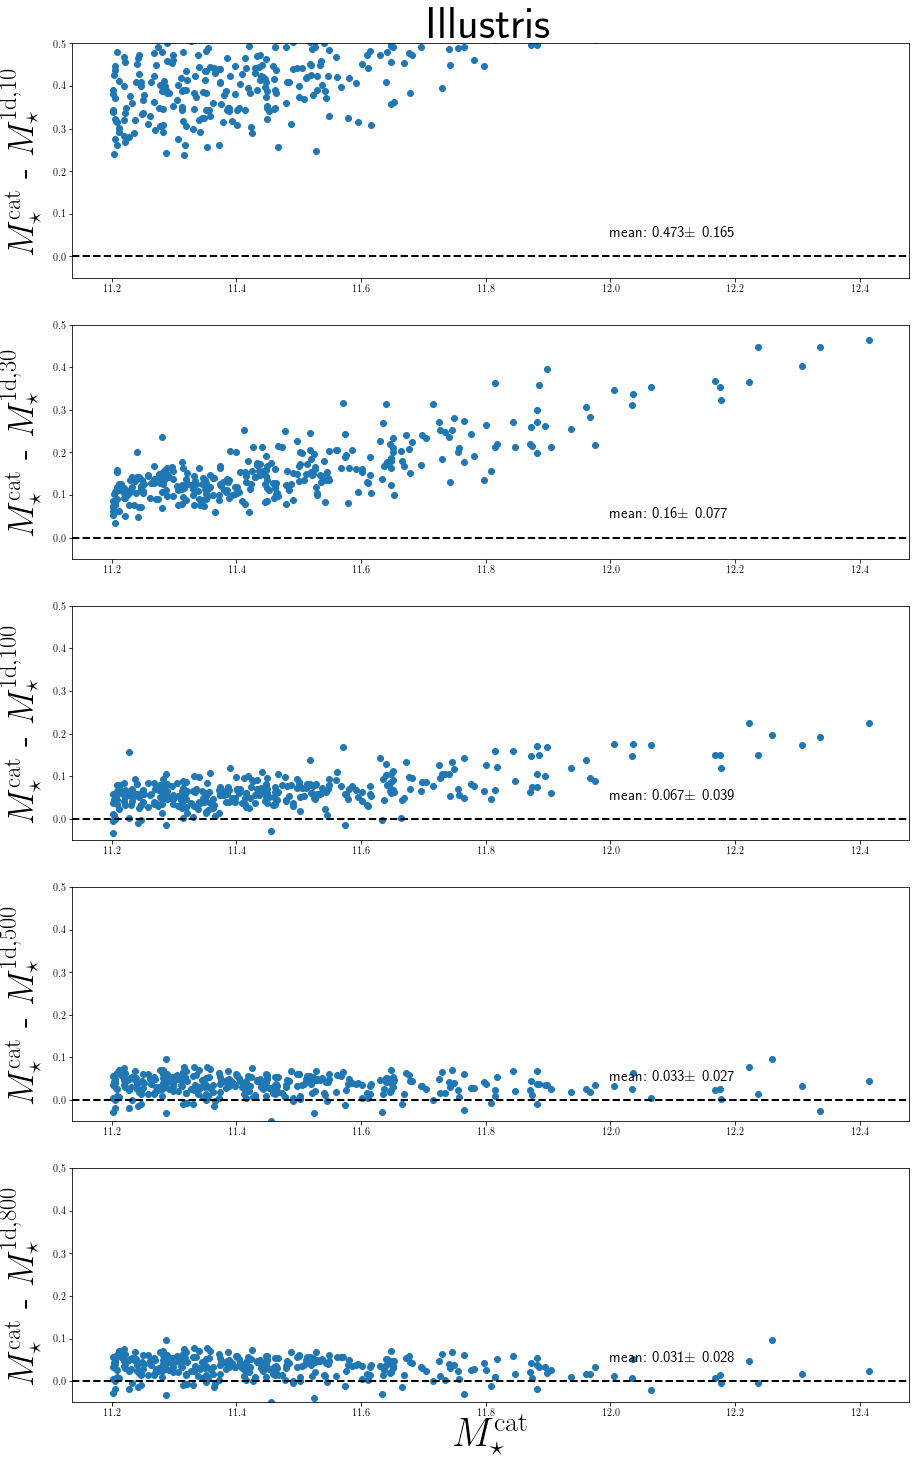

In [31]:
plt.figure(figsize=[15,25])
ax1=plt.subplot(511)
ax2=plt.subplot(512)
ax3=plt.subplot(513)
ax4=plt.subplot(514)
ax5=plt.subplot(515)


ax1.scatter(illustris_m_cat, illustris_m_cat - illustris_m_1d_10)
# ax1.plot(xs, illustris_diff_cat_post_line(xs))
ax1.axhline(0,c="k",linewidth=2,linestyle='--')
ax1.text(12, 0.05,'mean: ' + str(round(np.mean(illustris_m_cat - illustris_m_1d_10),3)) + r'$\pm$ '+\
         str(round(np.std(illustris_m_cat - illustris_m_1d_10),3)), fontsize=15)
ax1.set_ylabel(r'$M_{\star}^{\mathrm{cat}}$ - $M_{\star}^{\mathrm{1d, 10}}$', fontsize=35)

ax2.scatter(illustris_m_cat, illustris_m_cat - illustris_m_1d_30)
# ax2.plot(xs, illustris_diff_cat_post_icl_line(xs))
ax2.axhline(0,c="k",linewidth=2,linestyle='--')
ax2.text(12, 0.05,'mean: ' + str(round(np.mean(illustris_m_cat - illustris_m_1d_30),3)) + r'$\pm$ '+\
         str(round(np.std(illustris_m_cat - illustris_m_1d_30),3)), fontsize=15)
ax2.set_ylabel(r'$M_{\star}^{\mathrm{cat}}$ - $M_{\star}^{\mathrm{1d, 30}}$', fontsize=35)

ax3.scatter(illustris_m_cat, illustris_m_cat - illustris_m_1d_100)
# ax3.plot(xs, illustris_diff_cat_1d100_line(xs))
ax3.axhline(0, c="k",linewidth=2, linestyle='--')
ax3.text(12, 0.05,'mean: ' + str(round(np.mean(illustris_m_cat - illustris_m_1d_100),3)) + r'$\pm$ '+\
         str(round(np.std(illustris_m_cat - illustris_m_1d_100),3)), fontsize=15)
ax3.set_ylabel(r'$M_{\star}^{\mathrm{cat}}$ - $M_{\star}^{\mathrm{1d, 100}}$', fontsize=35)

ax4.scatter(illustris_m_cat, illustris_m_cat - illustris_m_1d_500)
# ax4.plot(xs, illustris_diff_1d_1d_30_line(xs))
ax4.axhline(0,c="k",linewidth=2,linestyle='--')
ax4.text(12, 0.05,'mean: ' + str(round(np.mean(illustris_m_cat - illustris_m_1d_500),3)) + r'$\pm$ '+\
         str(round(np.std(illustris_m_cat - illustris_m_1d_500),3)), fontsize=15)
ax4.set_ylabel(r'$M_{\star}^{\mathrm{cat}}$ - $M_{\star}^{\mathrm{1d, 500}}$', fontsize=35)

ax5.scatter(illustris_m_cat, illustris_m_cat - illustris_m_1d_800)
# ax5.plot(xs, illustris_diff_cat_1dextrap_line(xs))
ax5.axhline(0,c="k",linewidth=2,linestyle='--')
ax5.text(12, 0.05,'mean: ' + str(round(np.mean(illustris_m_cat - illustris_m_1d_800),3)) + r'$\pm$ '+\
         str(round(np.std(illustris_m_cat - illustris_m_1d_800),3)), fontsize=15)
ax5.set_ylabel(r'$M_{\star}^{\mathrm{cat}}$ - $M_{\star}^{\mathrm{1d, 800}}$', fontsize=35)




ax5.set_xlabel('$M_{\star}^{\mathrm{cat}}$', fontsize=40)
ax1.set_title('Illustris', fontsize=45)
#plt.tight_layout()

for ax in [ax1,ax2,ax3,ax4,ax5]:
    ax.set_ylim([-0.05,0.5])

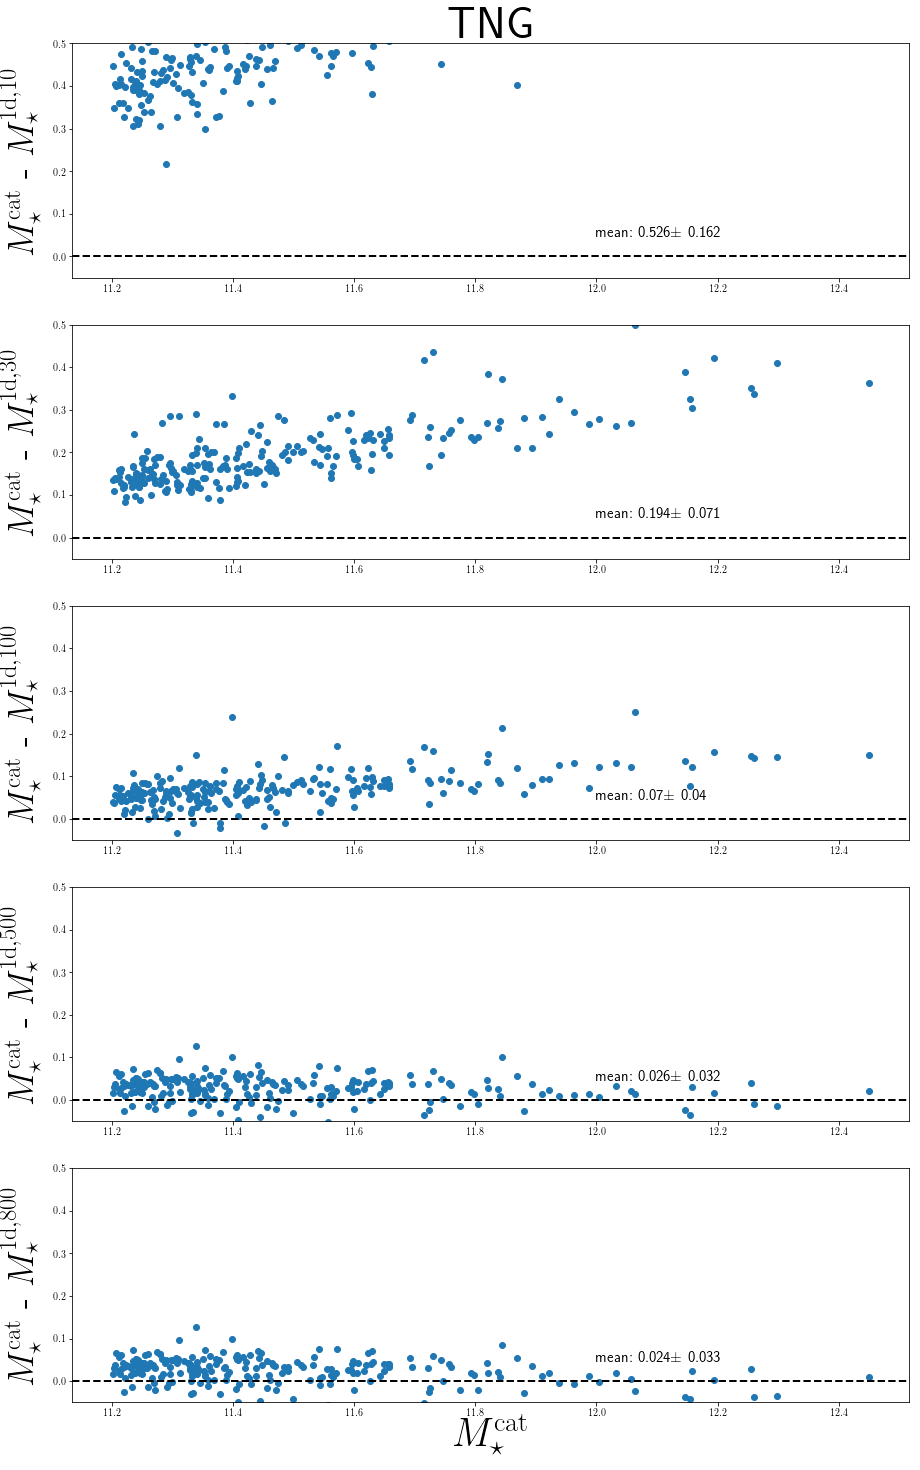

In [32]:
plt.figure(figsize=[15,25])
ax1=plt.subplot(511)
ax2=plt.subplot(512)
ax3=plt.subplot(513)
ax4=plt.subplot(514)
ax5=plt.subplot(515)


ax1.scatter(tng_m_cat, tng_m_cat - tng_m_1d_10)
# ax1.plot(xs, tng_diff_cat_post_line(xs))
ax1.axhline(0,c="k",linewidth=2,linestyle='--')
ax1.text(12, 0.05,'mean: ' + str(round(np.mean(tng_m_cat - tng_m_1d_10),3)) + r'$\pm$ '+\
         str(round(np.std(tng_m_cat - tng_m_1d_10),3)), fontsize=15)
ax1.set_ylabel(r'$M_{\star}^{\mathrm{cat}}$ - $M_{\star}^{\mathrm{1d, 10}}$', fontsize=35)

ax2.scatter(tng_m_cat, tng_m_cat - tng_m_1d_30)
# ax2.plot(xs, tng_diff_cat_post_icl_line(xs))
ax2.axhline(0,c="k",linewidth=2,linestyle='--')
ax2.text(12, 0.05,'mean: ' + str(round(np.mean(tng_m_cat - tng_m_1d_30),3)) + r'$\pm$ '+\
         str(round(np.std(tng_m_cat - tng_m_1d_30),3)), fontsize=15)
ax2.set_ylabel(r'$M_{\star}^{\mathrm{cat}}$ - $M_{\star}^{\mathrm{1d, 30}}$', fontsize=35)

ax3.scatter(tng_m_cat, tng_m_cat - tng_m_1d_100)
# ax3.plot(xs, tng_diff_cat_1d100_line(xs))
ax3.axhline(0, c="k",linewidth=2, linestyle='--')
ax3.text(12, 0.05,'mean: ' + str(round(np.mean(tng_m_cat - tng_m_1d_100),3)) + r'$\pm$ '+\
         str(round(np.std(tng_m_cat - tng_m_1d_100),3)), fontsize=15)
ax3.set_ylabel(r'$M_{\star}^{\mathrm{cat}}$ - $M_{\star}^{\mathrm{1d, 100}}$', fontsize=35)

ax4.scatter(tng_m_cat, tng_m_cat - tng_m_1d_500)
# ax4.plot(xs, tng_diff_1d_1d_30_line(xs))
ax4.axhline(0,c="k",linewidth=2,linestyle='--')
ax4.text(12, 0.05,'mean: ' + str(round(np.mean(tng_m_cat - tng_m_1d_500),3)) + r'$\pm$ '+\
         str(round(np.std(tng_m_cat - tng_m_1d_500),3)), fontsize=15)
ax4.set_ylabel(r'$M_{\star}^{\mathrm{cat}}$ - $M_{\star}^{\mathrm{1d, 500}}$', fontsize=35)

ax5.scatter(tng_m_cat, tng_m_cat - tng_m_1d_800)
# ax5.plot(xs, tng_diff_cat_1dextrap_line(xs))
ax5.axhline(0,c="k",linewidth=2,linestyle='--')
ax5.text(12, 0.05,'mean: ' + str(round(np.mean(tng_m_cat - tng_m_1d_800),3)) + r'$\pm$ '+\
         str(round(np.std(tng_m_cat - tng_m_1d_800),3)), fontsize=15)
ax5.set_ylabel(r'$M_{\star}^{\mathrm{cat}}$ - $M_{\star}^{\mathrm{1d, 800}}$', fontsize=35)




ax5.set_xlabel('$M_{\star}^{\mathrm{cat}}$', fontsize=40)
ax1.set_title('TNG', fontsize=45)
#plt.tight_layout()

for ax in [ax1,ax2,ax3,ax4,ax5]:
    ax.set_ylim([-0.05,0.5])